In [1]:
import numpy as np
import seaborn as sns
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Monthly video count plots for each search query

In [2]:
# Load data from your SQLite DB
db_path = "/netfiles/compethicslab/hashtag-hijacking/youtube.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM youtube_videos", conn)

conn.close()

df["published_at"] = pd.to_datetime(df["published_at"], errors="raise")

df["year_month"] = df["published_at"].dt.to_period("M")
df_filtered = df[df['year_month'] < pd.to_datetime('2025-04-01').to_period("M")]

video_counts = (
    df_filtered.groupby(["search_query", "year_month"])
    .size()
    .reset_index(name="video_count")
)

pivot_counts = video_counts.pivot(index="year_month", columns="search_query", values="video_count").fillna(0)


/tmp/ipykernel_1181374/3364013397.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["published_at"].dt.to_period("M")


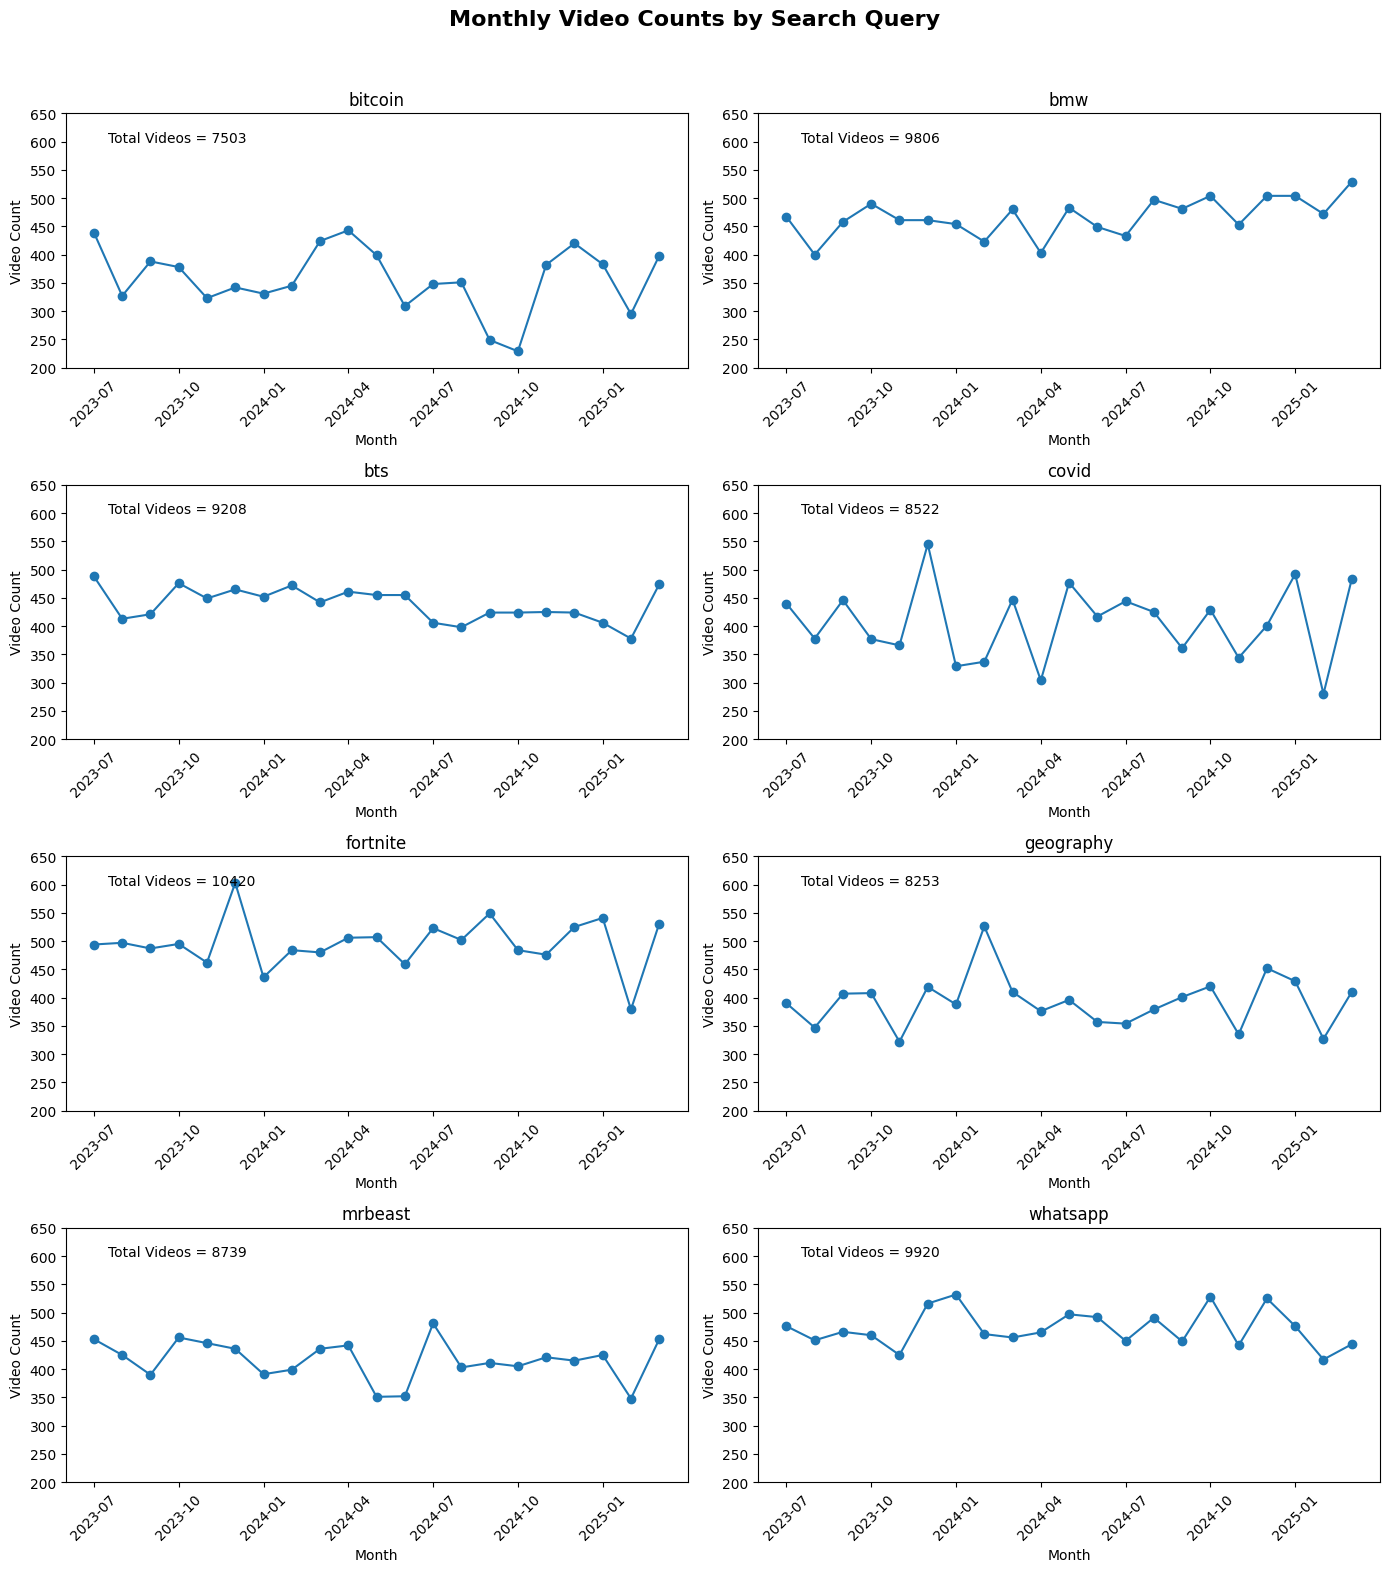

In [3]:
queries = video_counts["search_query"].unique()
query_counts = df_filtered.groupby("search_query").size().reset_index(name="video_count")

rows = (len(queries) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 4))
axes = axes.flatten()

for i, query in enumerate(queries):
    ax = axes[i]
    subset = video_counts[video_counts["search_query"] == query]
    
    ax.plot(
        subset["year_month"].astype(str),
        subset["video_count"],
        marker="o",
        linestyle="-"
    )
    
    ax.set_title(query, fontsize=12)
    ax.set_xlabel("Month")
    ax.set_ylabel("Video Count")
    ax.set_xticks(ax.get_xticks()[::3])
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylim(200, 650)
    ax.text(0.5, 600, f"Total Videos = {query_counts[query_counts['search_query'] == query]['video_count'].values[0]}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Monthly Video Counts by Search Query", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [4]:
total_videos = df_filtered['video_id'].nunique()
print(f"Total unique videos: {total_videos}")
print(f"Total video entries (including duplicates): {len(df_filtered)}")

Total unique videos: 72288
Total video entries (including duplicates): 72371


## Category distribution for each search query (video count and percentages)

In [5]:
df['category_id'] = df['category_id'].fillna("").astype(str)
category_mapping = {
    "1": "Film & Animation",
    "2": "Autos & Vehicles",
    "10": "Music",
    "15": "Pets & Animals",
    "17": "Sports",
    "18": "Short Movies",
    "19": "Travel & Events",
    "20": "Gaming",
    "21": "Videoblogging",
    "22": "People & Blogs",
    "23": "Comedy",
    "24": "Entertainment",
    "25": "News & Politics",
    "26": "Howto & Style",
    "27": "Education",
    "28": "Science & Technology",
    "29": "Nonprofits & Activism",
    "30": "Movies",
    "31": "Anime/Animation",
    "32": "Action/Adventure",
    "33": "Classics",
    "34": "Comedy",
    "35": "Documentary",
    "36": "Drama",
    "37": "Family",
    "38": "Foreign",
    "39": "Horror",
    "40": "Sci-Fi/Fantasy",
    "41": "Thriller",
    "42": "Shorts",
    "43": "Shows",
    "44": "Trailers"
}

df['category_name'] = df['category_id'].map(category_mapping).fillna("Unknown")
category_tables = {}

for query in df['search_query'].unique():
    subset = df[df['search_query'] == query]
    counts = subset['category_name'].value_counts().reset_index()
    counts.columns = ['Category', 'Video Count']
    counts['Percentage'] = (counts['Video Count'] / counts['Video Count'].sum() * 100).round(2)
    category_tables[query] = counts

for query, table in category_tables.items():
    print(f"\n=== Category Distribution for Query: {query} ===")
    print(table.to_string(index=False))


=== Category Distribution for Query: bmw ===
             Category  Video Count  Percentage
     Autos & Vehicles        11714       53.59
       People & Blogs         6638       30.37
        Entertainment         1081        4.95
               Gaming          995        4.55
                Music          266        1.22
            Education          253        1.16
               Sports          171        0.78
 Science & Technology          140        0.64
      Travel & Events          139        0.64
        Howto & Style          120        0.55
     Film & Animation          119        0.54
      News & Politics          108        0.49
               Comedy           99        0.45
       Pets & Animals           13        0.06
Nonprofits & Activism            3        0.01

=== Category Distribution for Query: mrbeast ===
             Category  Video Count  Percentage
        Entertainment         3865       35.16
       People & Blogs         3499       31.83
           

In [6]:
counts = df.groupby(['search_query', 'category_name']).size().reset_index(name='Video Count')
counts['Percentage'] = counts.groupby('search_query')['Video Count'].transform(lambda x: round(x / x.sum() * 100, 2))
table = counts.pivot(index='search_query', columns='category_name', values='Percentage').fillna(0)
table = table.reindex(sorted(table.columns), axis=1)
print(table)

category_name  Autos & Vehicles  Comedy  Education  Entertainment  \
search_query                                                        
bitcoin                    0.12    0.45      32.98          13.31   
bmw                       53.59    0.45       1.16           4.95   
bts                        0.28    2.11       1.04          35.91   
covid                      0.27    2.45      11.86           9.78   
fortnite                   0.02    0.40       0.12           4.15   
geography                  0.14    0.72      41.01          12.43   
mrbeast                    0.37    2.72       4.99          35.16   
whatsapp                   0.21    2.56       7.56           8.94   

category_name  Film & Animation  Gaming  Howto & Style  Movies  Music  \
search_query                                                            
bitcoin                    0.26    1.51           3.21    0.09   0.66   
bmw                        0.54    4.55           0.55    0.00   1.22   
bts              

## Engagement plots for each video category

/tmp/ipykernel_1181374/1778315161.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


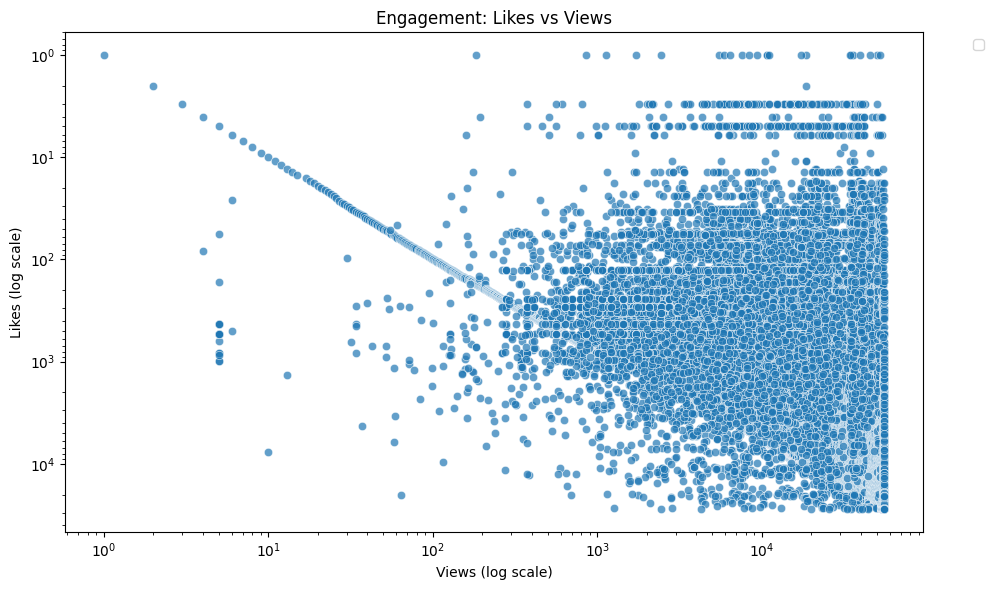

/tmp/ipykernel_1181374/1778315161.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


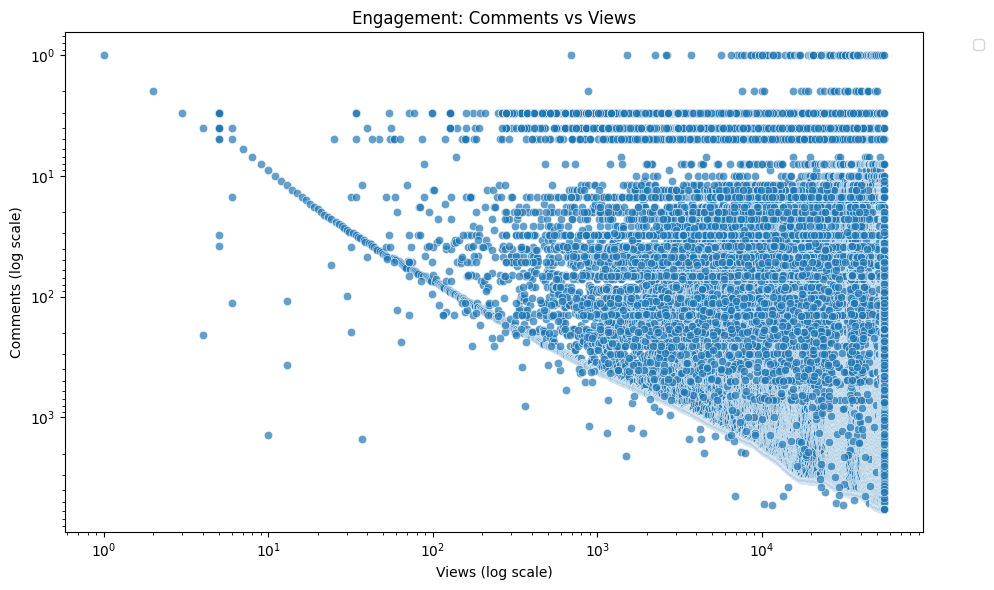

In [7]:
# Like count vs view count
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtered, x='view_count', y='like_count', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Engagement: Likes vs Views")
plt.xlabel("Views (log scale)")
plt.ylabel("Likes (log scale)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Comment count vs view count
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtered, x='view_count', y='comment_count', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Engagement: Comments vs Views")
plt.xlabel("Views (log scale)")
plt.ylabel("Comments (log scale)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

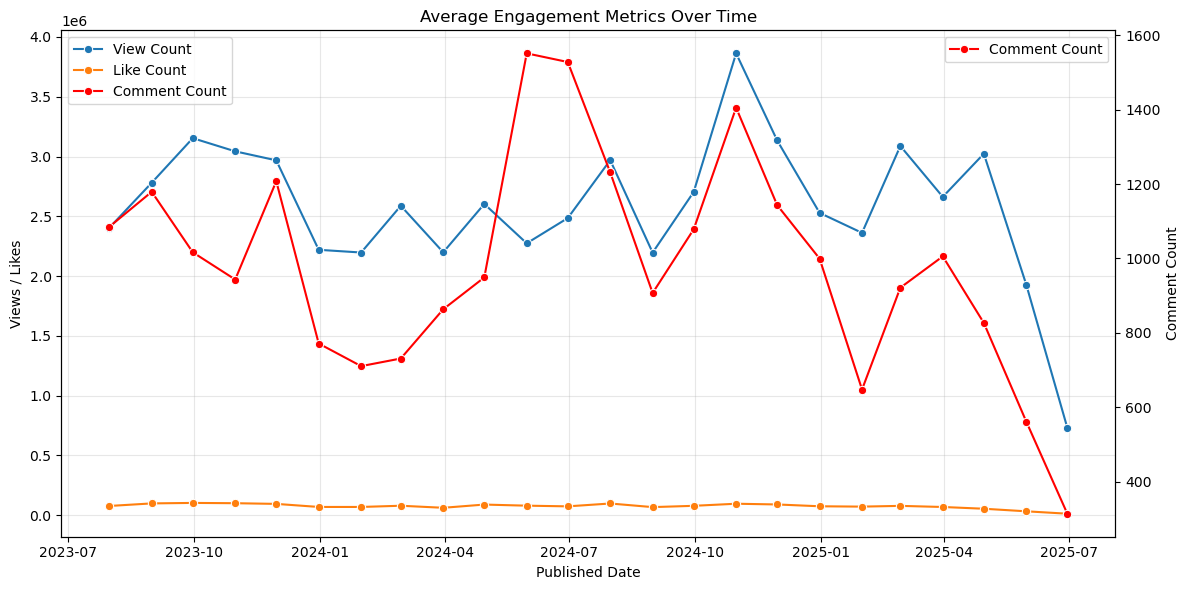

In [36]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=df_time, x='published_at', y='view_count', marker='o', label='View Count', ax=ax1)
sns.lineplot(data=df_time, x='published_at', y='like_count', marker='o', label='Like Count', ax=ax1)
ax1.set_ylabel("Views / Likes")
ax1.set_xlabel("Published Date")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
sns.lineplot(data=df_time, x='published_at', y='comment_count', marker='o', color='red', label='Comment Count', ax=ax2)
ax2.set_ylabel("Comment Count")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("Average Engagement Metrics Over Time")
plt.tight_layout()
plt.show()


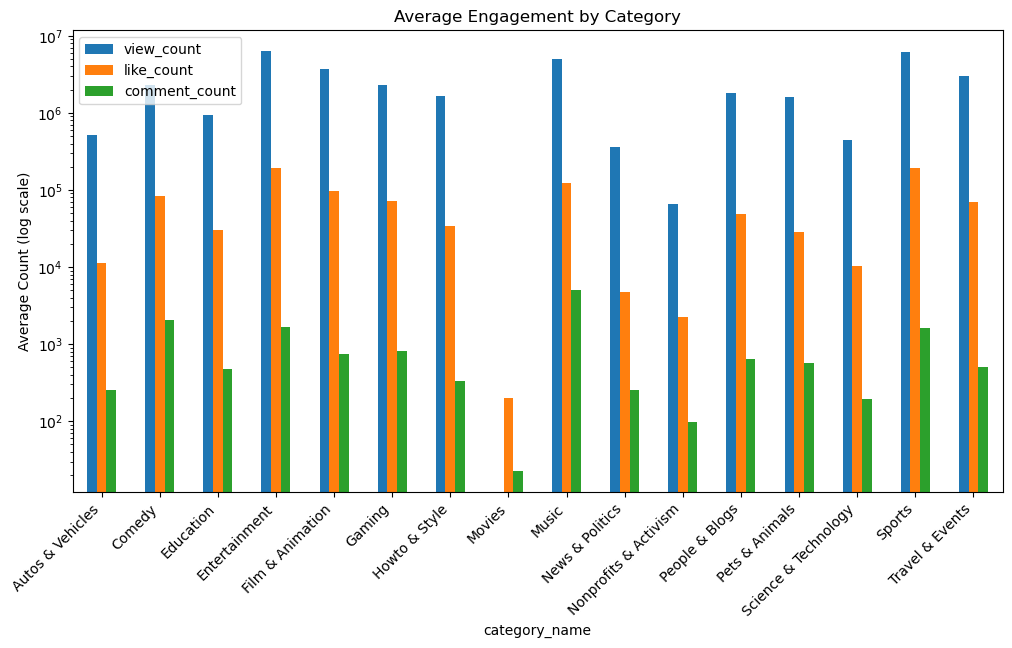

In [24]:
category_avg = df.groupby('category_name')[['view_count','like_count','comment_count']].mean()

category_avg.plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=45, ha='right')
plt.yscale('log') 
plt.ylabel('Average Count (log scale)')
plt.title('Average Engagement by Category')
plt.show()

## Number of unique videos per category

/tmp/ipykernel_2461699/1160782139.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


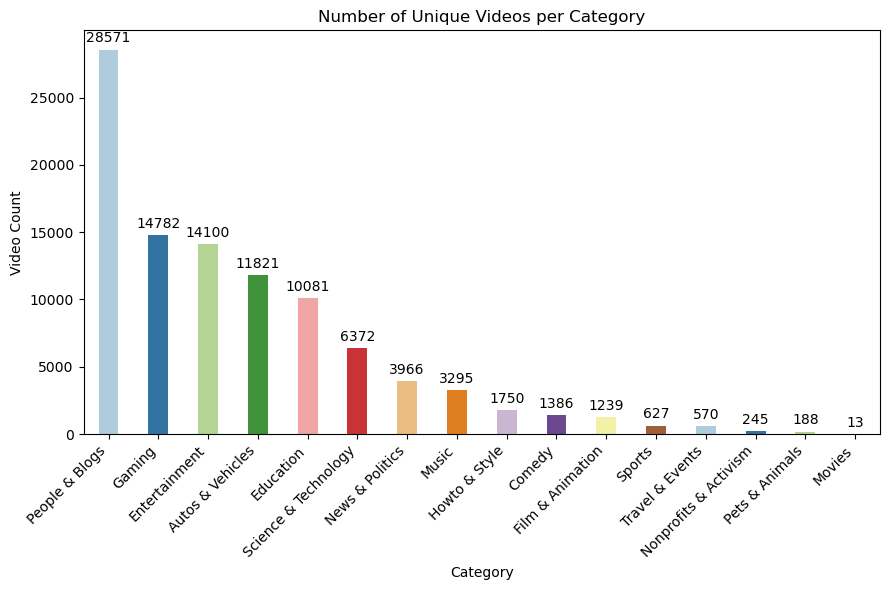

In [35]:
df_count = df.groupby('category_name')['video_id'].nunique().reset_index()
df_count.columns = ['category_name', 'video_count']
df_count = df_count.sort_values('video_count', ascending=False)

plt.figure(figsize=(9,6))
ax = sns.barplot(
    data=df_count,
    x='category_name',
    y='video_count',
    palette=sns.color_palette("Paired", n_colors=len(df_count)),
    width=0.4
)
plt.xticks(rotation=45, ha='right')
plt.title("Number of Unique Videos per Category")
plt.ylabel("Video Count")
plt.xlabel("Category")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10,
                xytext=(0, 3),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [37]:
channel_counts = df.groupby("search_query")["channel_id"].nunique().reset_index()
channel_counts.columns = ["search_query", "unique_channel_count"]

print(channel_counts)

  search_query  unique_channel_count
0      bitcoin                  3577
1          bmw                 11315
2          bts                  5122
3        covid                  8173
4     fortnite                  3527
5    geography                  4099
6      mrbeast                  5842
7     whatsapp                  6324


In [2]:
import sqlite3
import pandas as pd

db_file = "/netfiles/compethicslab/hashtag-hijacking/youtube.db"
conn = sqlite3.connect(db_file)

query_name = 'bmw'
start_date = '2023-07-01T00:00:00'
end_date = '2023-08-01T00:00:00'

# Load data as DataFrame
df = pd.read_sql_query(f"""
    SELECT *
    FROM youtube_videos
    WHERE search_query = '{query_name}' 
      AND published_at >= '{start_date}' 
      AND published_at < '{end_date}'
""", conn)

print(f"Number of videos: {len(df)}")
df.head()  # show first 5 rows

conn.close()


Number of videos: 467
